##### <ins>Importing Datasets and Dependencies</ins>

In [321]:
# Import required libs

# from IPython.display import display
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as pyplot
from micromlgen import port

# Load dataset
heartattack_all_LE = pd.read_csv('../datasets/heart_attack_risk_dataset.csv')
heartattack_LE_OHE = pd.read_csv('../datasets/heart_attack_risk_dataset.csv')

##### <ins>Feature Encoding</ins>

In [322]:
# Initialize Encoders
leGender = LabelEncoder()       # Female, Male
leHML = LabelEncoder()          # High, Moderate, Low
leChestPain = LabelEncoder()    # Non-anginal, Asymptomatic, Typical, Atypical
leThalassemia = LabelEncoder()  # Normal, Fixed Defect, Reversible Defect
leECG = LabelEncoder()          # Normal, ST-T abnormality, Left ventricular hypertrophy

In [323]:
# Encode categorical columns using LE
heartattack_all_LE['Gender'] = leGender.fit_transform(heartattack_all_LE['Gender'])

heartattack_all_LE['Physical_Activity_Level'] = leHML.fit_transform(heartattack_all_LE['Physical_Activity_Level'])
heartattack_all_LE['Stress_Level'] = leHML.fit_transform(heartattack_all_LE['Stress_Level'])
heartattack_all_LE['Heart_Attack_Risk'] = leHML.fit_transform(heartattack_all_LE['Heart_Attack_Risk'])

heartattack_all_LE['Chest_Pain_Type'] = leChestPain.fit_transform(heartattack_all_LE['Chest_Pain_Type'])
heartattack_all_LE['Thalassemia'] = leThalassemia.fit_transform(heartattack_all_LE['Thalassemia'])
heartattack_all_LE['ECG_Results'] = leECG.fit_transform(heartattack_all_LE['ECG_Results'])

##### <ins>Splitting the Datasets into Features and Labels + Training and Testing Datasets</ins>

In [324]:
# Split DF into Features and Labels
Features_he_all_LE = heartattack_all_LE.iloc[:, :19]
Labels_he_all_LE = heartattack_all_LE.iloc[:, 19:]

# Splitting into Train- and Test-sets
f_train_he_le, f_test_he_le, l_train_he_le, l_test_he_le = train_test_split(
    Features_he_all_LE, 
    Labels_he_all_LE, 
    test_size=0.3, 
    random_state=38
)

##### <ins>Fitting a Donor Model to Find The Best Amount of Trees</ins>

In [325]:
# Initialising XGB Classifier
pre_xgbc_le =  XGBClassifier(
    objective='multi:softmax',  # Specify the multi-class classification task
    num_class=3,                # Number of classes (Low, Moderate, High)
    max_depth=3,                # Maximum depth of the trees
    learning_rate=0.1,          # Learning rate for the model
    n_estimators=5000,          # Number of boosting rounds (iterations)
    early_stopping_rounds=50,   # Early stopping to find best Iteration
)

# Fitting 
evalset = [
    (f_train_he_le, l_train_he_le), 
    (f_test_he_le, l_test_he_le)
]
pre_xgbc_le.fit(
    f_train_he_le, l_train_he_le, 
    eval_set=evalset, 
    verbose=False
)
bI = pre_xgbc_le.best_iteration

##### <ins>Fitting The Final Model</ins>

In [326]:
xgbc_le =  XGBClassifier(
    objective='multi:softmax',  # Specify the multi-class classification task
    num_class=3,                # Number of classes (Low, Moderate, High)
    max_depth=3,                # Maximum depth of the trees
    learning_rate=0.2,          # Learning rate for the model
    n_estimators=bI,          # Number of boosting rounds (iterations)
)

xgbc_le.fit(f_train_he_le, l_train_he_le)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=38, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

##### <ins>(Ex-)Porting The Model to C++</ins>

In [327]:
with open('../exported_models/XGBC_har_LE.h', 'w') as file:
    file.write(port(xgbc_le))

##### <ins>Arduino Test-Case Code Printer</ins>

In [328]:
size = 50

for x in range(size):
    print(f'float X_{x+1}[] = {{' , end="")    
    kek = f_test_he_le.values[x]
    for i in range(len(kek)):
        if i < 18:
            print(kek[i], end=", ")
        else:
            print(kek[i], end="};\n")
    print(f'int result_{x+1} = classifier.predict(X_{x+1});')
    print(f'Serial.print("Result of predict with input X{x+1}:");')
    print(f'Serial.print(result_{x+1});')
    print(f'Serial.println("  |  The true label is: {l_test_he_le.values[x][0]}");')
    print('delay(500);\n')
    
print('Serial.println("Looping...");')
print('delay(5000);')

float X_1[] = {73.0, 0.0, 0.0, 0.0, 1.0, 26.54, 0.0, 0.0, 239.6, 147.0, 104.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 146.0};
int result_1 = classifier.predict(X_1);
Serial.print("Result of predict with input X1:");
Serial.print(result_1);
Serial.println("  |  The true label is: 0");
delay(500);

float X_2[] = {40.0, 1.0, 0.0, 0.0, 1.0, 29.33, 0.0, 1.0, 253.1, 106.0, 106.0, 0.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 161.0};
int result_2 = classifier.predict(X_2);
Serial.print("Result of predict with input X2:");
Serial.print(result_2);
Serial.println("  |  The true label is: 1");
delay(500);

float X_3[] = {21.0, 1.0, 0.0, 1.0, 2.0, 32.13, 0.0, 1.0, 160.4, 154.0, 127.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 186.0};
int result_3 = classifier.predict(X_3);
Serial.print("Result of predict with input X3:");
Serial.print(result_3);
Serial.println("  |  The true label is: 0");
delay(500);

float X_4[] = {40.0, 0.0, 0.0, 0.0, 0.0, 28.85, 0.0, 0.0, 287.8, 117.0, 68.0, 0.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 179.0

##### <ins>Performance Metrics and Evaluation</ins>

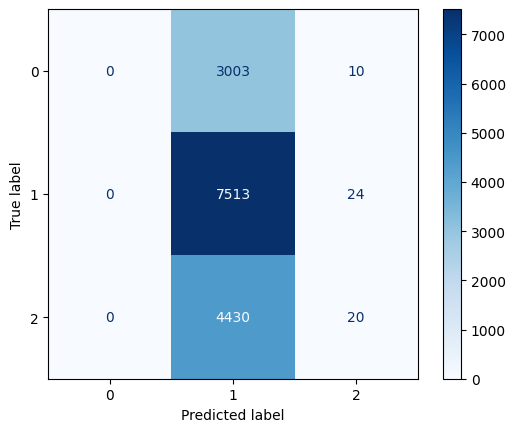

              precision    recall  f1-score   support

           0      0.000     0.000     0.000      3013
           1      0.503     0.997     0.668      7537
           2      0.370     0.004     0.009      4450

    accuracy                          0.502     15000
   macro avg      0.291     0.334     0.226     15000
weighted avg      0.362     0.502     0.338     15000

Train Accuracy LE: 	0.5012
Test Accuracy LE: 	0.5022


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
ConfusionMatrixDisplay.from_estimator(xgbc_le, f_test_he_le, l_test_he_le, cmap='Blues')
pyplot.show()

print(metrics.classification_report(l_test_he_le, test_preds, digits = 3, zero_division=0)) # No clue what zero_division does or why it surpresses warnings

train_preds= xgbc_le.predict(f_train_he_le) # Predictions based on Training-Data
test_preds = xgbc_le.predict(f_test_he_le)  # Predictions based on Test-Data
print(f'Train Accuracy LE: \t{accuracy_score(l_train_he_le, train_preds)}')
print(f'Test Accuracy LE: \t{accuracy_score(l_test_he_le, test_preds)}')

##### <ins>Stuff from ["Tune XGBoost Performance with Learning Curves"](https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/)</ins>

In [330]:
# # define the datasets to evaluate each iteration
# model = XGBClassifier(objective='multi:softmax',  # Specify the multi-class classification task
#     num_class=3,                # Number of classes (Low, Moderate, High)
#     max_depth=8,                # Maximum depth of the trees
#     learning_rate=0.1,          # Learning rate for the model
#     n_estimators=500,           # Number of boosting rounds (iterations) (n=22 best according to brute force eval)
#     random_state=0,             # Set random state for reproducibility
#     eval_metric='mlogloss'      # alternativ: eval_metric='merror'
# )
# evalset = [(f_train_he_le, l_train_he_le), (f_test_he_le, l_test_he_le)]


# # fit the model
# model.fit(f_train_he_le, l_train_he_le, eval_set=evalset, verbose=False)

# yhat = model.predict(f_test_he_le)
# score = accuracy_score(l_test_he_le, yhat)
# print('Accuracy: %.3f' % score)

# # retrieve performance metrics
# # results = model.evals_result()

# # pyplot.xlabel('Iterations')
# # pyplot.ylabel('Log Loss')
# # # plot learning curves
# # pyplot.plot(results['validation_0']['mlogloss'], label='train')
# # pyplot.plot(results['validation_1']['mlogloss'], label='test')
# # # pyplot.plot(results['validation_0']['merror'], label='train')
# # # pyplot.plot(results['validation_1']['merror'], label='test')
# # # show the legend
# # pyplot.legend()
# # # show the plot
# # pyplot.show()
# # print(min(results['validation_0']['mlogloss']))
# # print(max(results['validation_0']['mlogloss']))
# # print(min(results['validation_1']['mlogloss']))
# # print(max(results['validation_1']['mlogloss']))

# min_train = min(results['validation_0']['mlogloss'])
# max_train = max(results['validation_0']['mlogloss'])
# min_test = min(results['validation_1']['mlogloss'])
# max_test = max(results['validation_1']['mlogloss'])

# print(f'Minimal Training Loss: \t{min_train} at Iteration: {results["validation_0"]["mlogloss"].index(min_train)+1}')
# print(f'Minimal Testing Loss: \t{min_test} at Iteration: {results["validation_1"]["mlogloss"].index(min_test)+1}')
# print(f'Maximal Training Loss: \t{max_train} at Iteration: {results["validation_0"]["mlogloss"].index(max_train)+1}')
# print(f'Maximal Testing Loss: \t{max_test} at Iteration: {results["validation_1"]["mlogloss"].index(max_test)+1}')
